# Adding the Lense-Thirring (LT) effect

Without any additional effects, the pericenter of Mercury doesn't precess

In [1]:
import rebound
import numpy as np

sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.add(m=1., hash="star") # Sun
sim.add(m=1.7e-7,a=0.39,e=0.21, hash="planet") # Mercury like
sim.move_to_com() # Moves to the center of momentum frame
ps = sim.particles
sim.integrate(1.)
print("pomega = %.16f"%sim.particles[1].pomega)

pomega = 0.0000000000000000


Now let's add the Lense-Thirring effect

In [2]:
import reboundx
rebx = reboundx.Extras(sim)
lt = rebx.load_force("lense_thirring")
rebx.add_force(lt)

We need to set the angular spin frequency vector of the Sun and its moment of inertia using the units we chose for our simulation above (AU, yr, Msun). We use the standard values given by Park et al. (2021)

In [3]:
lt.params["lt_c"] = 63241.077 # AU/yr
Omega = 90.42                 # rad/yr
Omega_RA = np.radians(286.13) # spin pole RA
Omega_Dec = np.radians(63.87) # spin pole Dec
Rsun_eq = 0.00465             # AU
Csun = 0.06884                # dimensionless moment of inertia I = C * MR^2

REBOUNDx needs the angular spin frequency vector components (Omega_x, Omega_y, Omega_z), so we convert from spherical coordinates (with polar angle $\theta = \pi/2 - $ dec)

In [4]:
ps["star"].params['Omega'] = rebound.spherical_to_xyz(magnitude=Omega, theta=np.pi/2 - Omega_Dec, phi=Omega_RA)
ps["star"].params["I"] = Csun*ps[0].m*Rsun_eq**2

Now we integrate as normal:

In [5]:
%%time
tmax = 5e3
Nout = 1000
times = np.linspace(0, tmax, Nout)
pomegas = np.zeros(Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    pomegas[i] = ps["planet"].pomega
print("pomega = {0}".format(ps[1].pomega))

pomega = -4.301820322183403e-07
CPU times: user 6.3 s, sys: 673 ms, total: 6.97 s
Wall time: 6.06 s


Over 10 centuries, the pericenter precession rate is 

In [6]:
arcsecPerRad = 206265
century = 100
print('Pericenter precession rate = {0:.3f}"/century'.format(ps['planet'].pomega*arcsecPerRad/(sim.t/century)))

Pericenter precession rate = -0.002"/century


as expected. Note that this is a small effect, about 7% of the solar oblateness precession rate for Mercury. We can also plot the pericenter vs time. Note that the positions and velocities are calculated to machine precision--the discrete steps early on are due to rounding errors in the calculation of orbital elements:

Text(0, 0.5, 'Longitude of Pericenter')

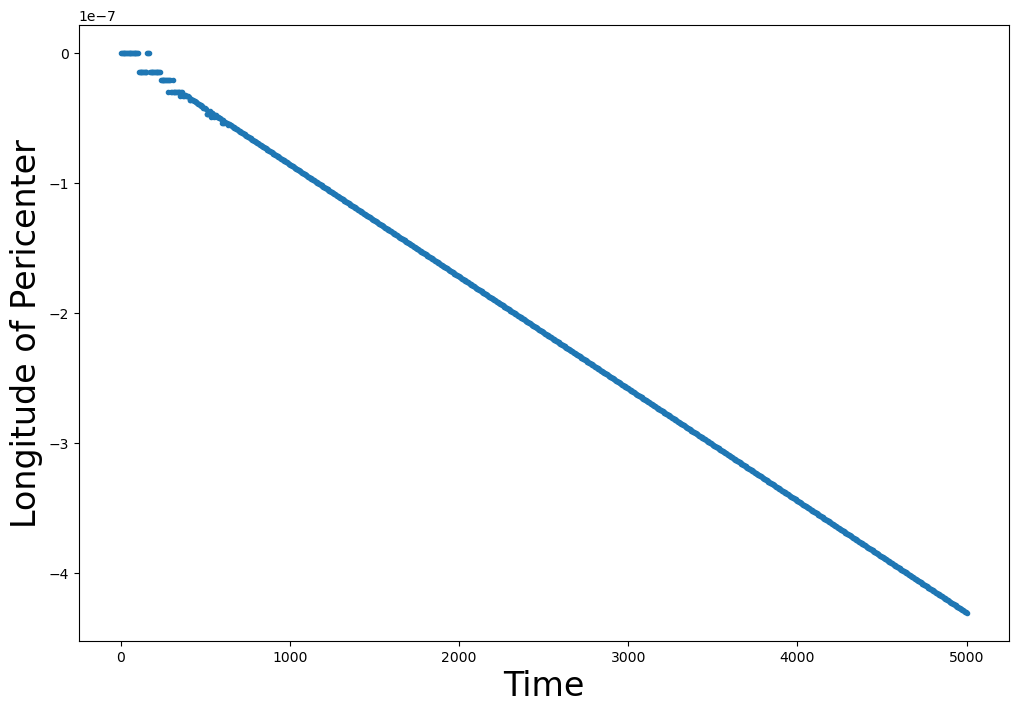

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, pomegas, '.')
ax.set_xlabel('Time', fontsize=24)
ax.set_ylabel('Longitude of Pericenter', fontsize=24)